<a href="https://colab.research.google.com/github/AnahVeronica/RANZCR_CLiP_Catheter_and_Line_Position_Challenge/blob/main/RANZCR_CLiP_Catheter_and_Line_Position_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount drive to access train and test tfrecords

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from PIL import Image
import tensorflow as tf
from IPython import display
import cv2 as cv

# Step 1: Read tf.record files in using td.data.TFRecord

In [24]:
Train_folder_path = '/content/drive/MyDrive/train_tfrecords'

In [25]:
TFRecord_filenames = []

In [26]:
for dirpath, dirnames, files in os.walk(Train_folder_path):
  for filename in files:
    TFRecord_filenames.append(os.path.join(dirpath, filename))



In [27]:
dataset_size = 30083

train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

# Create a training and a validation datasets
full_dataset = tf.data.TFRecordDataset(TFRecord_filenames)
full_dataset = full_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size) #.cache()
val_dataset = full_dataset.skip(train_size).take(val_size)

In [28]:
for raw_record in train_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    if False:  # Change this to True if you want to see the data.  I turned it off because it's long and it make this notebook hard to read.
        print(example)

In [29]:
feature_dictionary = {
    'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'StudyInstanceUID': tf.io.FixedLenFeature([], tf.string),    
    'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [30]:
# Define two parsing functions that will turn the TFRecord back into an array and a label        
def _parse_function(example, feature_dictionary=feature_dictionary):
    # Parse the input `tf.train.Example` proto using the feature_dictionary.
    # Create a description of the features.
    parsed_example = tf.io.parse_example(example, feature_dictionary)
    return parsed_example



In [58]:
def data_generator():

  clahe = cv.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))

  data = list(train_dataset.take(1).as_numpy_iterator())

  labels = []

  for key in data[0].keys():
    if key != 'image' and key != 'StudyInstanceUID' and key!= 'Swan Ganz Catheter Present':
      labels.append(data[0][key])
    
  img = Image.open(io.BytesIO(data[0]['image']))
  image = np.asarray(img)
  clahe_img = clahe.apply(image)

  yield (clahe_img, labels)

In [32]:
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [56]:
 data = data_generator()

In [57]:
[x for x in data]

[(array([[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   2,   2,   2],
         [  1,   1,   1, ...,  13,  11,  13],
         ...,
         [197, 202, 206, ..., 125, 117, 108],
         [  3,   3,   3, ...,   2,   2,   2],
         [  1,   1,   0, ...,   1,   1,   0]], dtype=uint8),
  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1])]

In [145]:
def create_dataset(train_dataset):

  train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train_dataset = train_dataset.map(generate_training_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

  features = list(train_dataset.take(1).as_numpy_iterator())

  return features

In [18]:
image, label = data_generator(train_dataset)

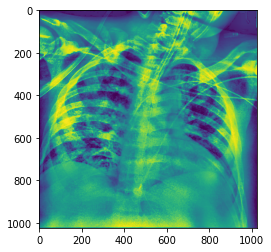

In [39]:
plt.imshow(image)